# Visualização Indicador Incidência 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
taxa_deteccao = pd.read_csv('../data/indicadores/visceral/indicador_15_taxa_incidencia_municipio_infeccao.csv')
taxa_deteccao = taxa_deteccao.set_index('CO_MN_INF')

In [3]:
total_casos = pd.read_csv('../data/indicadores/visceral/indicador_14_total_casos_novos_municipio_infeccao.csv')
total_casos = total_casos.set_index('CO_MN_INF')

In [4]:
municipios = pd.read_csv('../data/processed/municipios.csv')

In [11]:
municipios.head()

,ibge_code,municipio,estado,mesorregiao,microrregiao
0,110001,Alta Floresta D'Oeste,Rondônia,Leste Rondoniense,Cacoal
1,110037,Alto Alegre dos Parecis,Rondônia,Leste Rondoniense,Cacoal
2,110040,Alto Paraíso,Rondônia,Leste Rondoniense,Ariquemes
3,110034,Alvorada D'Oeste,Rondônia,Leste Rondoniense,Alvorada D'Oeste
4,110002,Ariquemes,Rondônia,Leste Rondoniense,Ariquemes


### 1) Alguns municípios vizinhos estão enfrentando uma taxa alta de casos. Como isso se relaciona com este município espacial e temporalmente? Quais municípios vizinhos estão tendo alta nas taxas?
- definir os municípios vizinhos

In [6]:
limitrofes = ['Ourilândia do Norte', 'Água Azul do Norte', 'São Félix do Xingu', 'Tucumã', 'Parauapebas', 'Bannach', 'Cumaru do Norte']
idx = []
for it in limitrofes:
    idx.append(municipios.loc[municipios.municipio == it, :].index.values[0])
limitrofes = municipios.loc[idx, :]
limitrofes = limitrofes.set_index('ibge_code')
limitrofes

,municipio,estado,mesorregiao,microrregiao
ibge_code,,,,
150543,Ourilândia do Norte,Pará,Sudeste Paraense,São Félix do Xingu
150034,Água Azul do Norte,Pará,Sudeste Paraense,Parauapebas
150730,São Félix do Xingu,Pará,Sudeste Paraense,São Félix do Xingu
150808,Tucumã,Pará,Sudeste Paraense,São Félix do Xingu
150553,Parauapebas,Pará,Sudeste Paraense,Parauapebas
150125,Bannach,Pará,Sudeste Paraense,São Félix do Xingu
150276,Cumaru do Norte,Pará,Sudeste Paraense,São Félix do Xingu


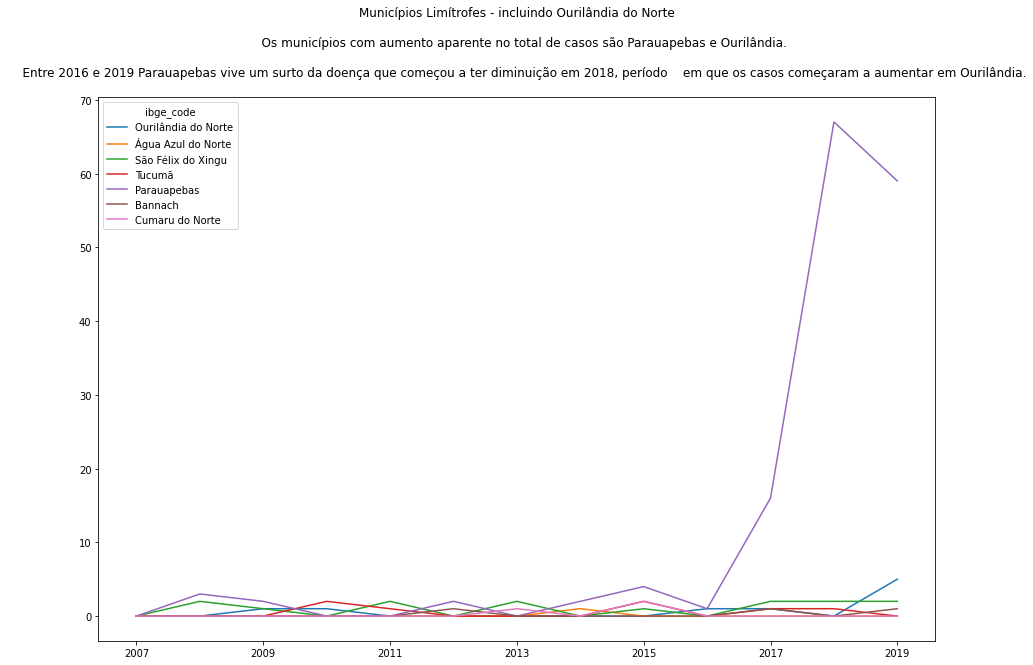

In [8]:
d = total_casos.loc[limitrofes.index,:].copy()
d.index = d.index.map(dict(zip(limitrofes.index, limitrofes.municipio)))
d.T.plot(
    kind='line', 
    figsize=(15,10),
    title='''Municípios Limítrofes - incluindo Ourilândia do Norte\n
    Os municípios com aumento aparente no total de casos são Parauapebas e Ourilândia.\n
    Entre 2016 e 2019 Parauapebas vive um surto da doença que começou a ter diminuição em 2018, período\
    em que os casos começaram a aumentar em Ourilândia.\n'''
);

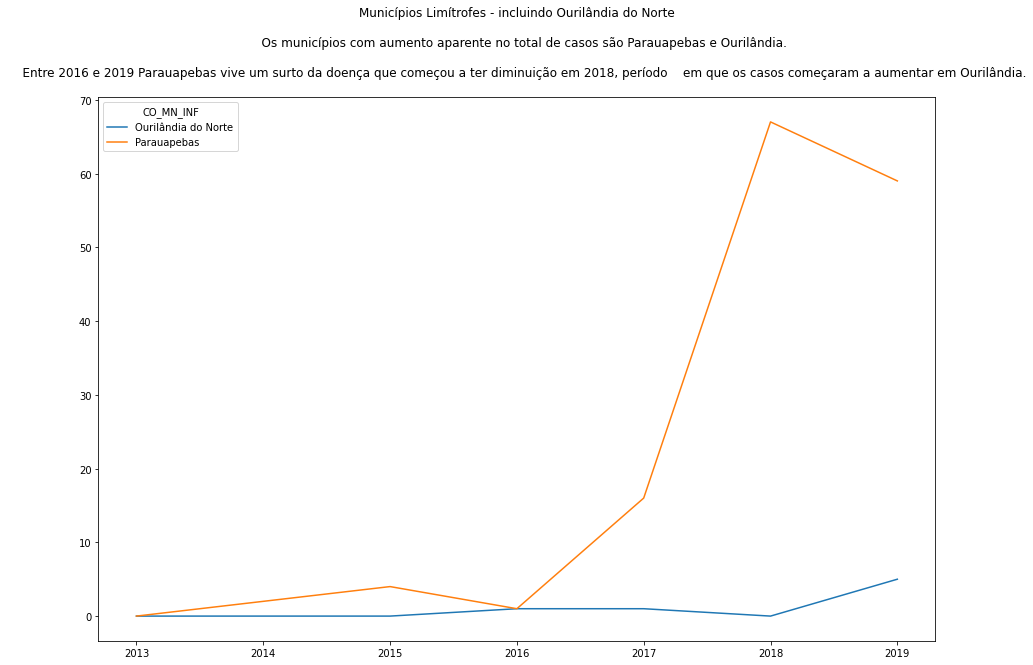

In [7]:
d = total_casos.loc[[150543, 150553], ['2013','2014','2015','2016','2017','2018','2019']].copy()
d.index = d.index.map({150543:'Ourilândia do Norte', 150553:'Parauapebas'})
d.T.plot(
    kind='line', 
    figsize=(15,10),
    title='''Municípios Limítrofes - incluindo Ourilândia do Norte\n
    Os municípios com aumento aparente no total de casos são Parauapebas e Ourilândia.\n
    Entre 2016 e 2019 Parauapebas vive um surto da doença que começou a ter diminuição em 2018, período\
    em que os casos começaram a aumentar em Ourilândia.\n'''
);

Entre 2007 e 2016 a quantidade de casos se mantém estável abaixo de 10 por ano. Entretanto, entre 2016 e 2018, especialmente, o município de Parauapebas vive um surto intenso. Entre 2018 e 2019, quando começa a diminuir os casos, Ourilândia experimenta aumento de notificações. Mas nada perto da quantidade enorme do vizinho.

### 2) Parauapebas viveu um surto de LV após 2016, os municípios vizinhos enfrentaram também uma alta de casos? Como isso se relaciona com este município espacial e temporalmente? Quais municípios vizinhos tiveram alta nas taxas?
- definir os municípios vizinhos de Parauapebas (ou da microrregião)

In [22]:
limitrofes = ['Marabá', 'Curionópolis', 'Canaã dos Carajás', 'Parauapebas', 'Água Azul do Norte', 'São Félix do Xingu']
idx = []
for it in limitrofes:
    idx.append(municipios.loc[municipios.municipio == it, :].index.values[0])
limitrofes = municipios.loc[idx, :]
limitrofes = limitrofes.set_index('ibge_code')
limitrofes


,municipio,estado,mesorregiao,microrregiao
ibge_code,,,,
150420,Marabá,Pará,Sudeste Paraense,Marabá
150277,Curionópolis,Pará,Sudeste Paraense,Parauapebas
150215,Canaã dos Carajás,Pará,Sudeste Paraense,Parauapebas
150553,Parauapebas,Pará,Sudeste Paraense,Parauapebas
150034,Água Azul do Norte,Pará,Sudeste Paraense,Parauapebas
150730,São Félix do Xingu,Pará,Sudeste Paraense,São Félix do Xingu


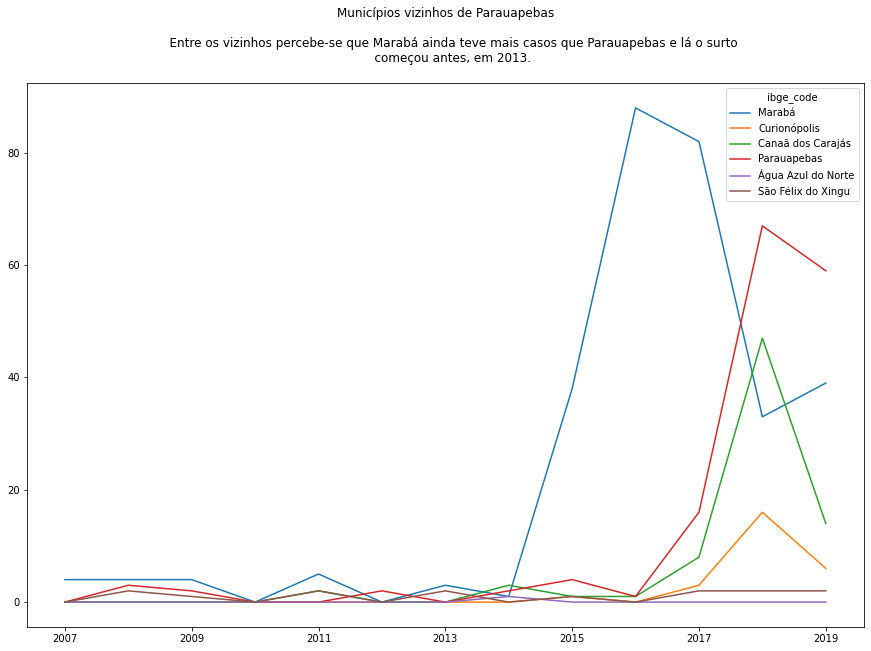

In [26]:
d = total_casos.loc[limitrofes.index,:].copy()
d.index = d.index.map(dict(zip(limitrofes.index, limitrofes.municipio)))
d.T.plot(
    kind='line', 
    figsize=(15,10),
    title='''Municípios vizinhos de Parauapebas\n
    Entre os vizinhos percebe-se que Marabá ainda teve mais casos que Parauapebas e lá o surto
    começou antes, em 2013.\n'''
);

In [27]:
microrregiao_parauapebas = municipios.loc[municipios.microrregiao == 'Parauapebas', :]
microrregiao_parauapebas = microrregiao_parauapebas.set_index('ibge_code')
microrregiao_parauapebas

,municipio,estado,mesorregiao,microrregiao
ibge_code,,,,
150034,Água Azul do Norte,Pará,Sudeste Paraense,Parauapebas
150215,Canaã dos Carajás,Pará,Sudeste Paraense,Parauapebas
150277,Curionópolis,Pará,Sudeste Paraense,Parauapebas
150295,Eldorado do Carajás,Pará,Sudeste Paraense,Parauapebas
150553,Parauapebas,Pará,Sudeste Paraense,Parauapebas


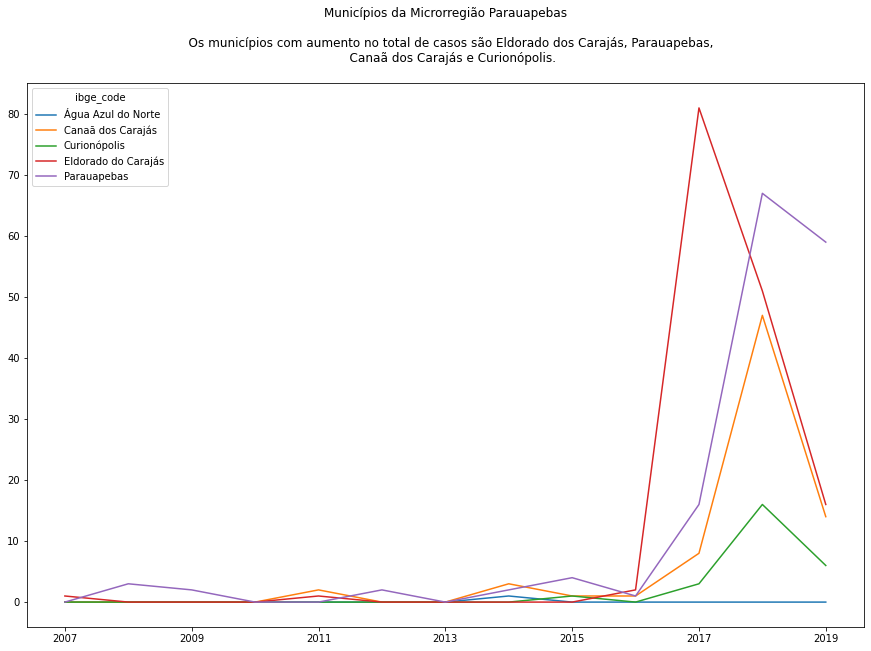

In [28]:
d = total_casos.loc[microrregiao_parauapebas.index,:].copy()
d.index = d.index.map(dict(zip(microrregiao_parauapebas.index, microrregiao_parauapebas.municipio)))
d.T.plot(
    kind='line', 
    figsize=(15,10),
    title='''Municípios da Microrregião Parauapebas\n
    Os municípios com aumento no total de casos são Eldorado dos Carajás, Parauapebas, 
    Canaã dos Carajás e Curionópolis.\n'''
);

Olhando os municípios da microrregião Parauapebas percebe-se que há municípios que tiveram surtos ainda piores como Eldorado dos Carajás, que 2017 notificou cerca de 80 casos contra menos de 5 no ano anterior, ou seja completamente fora do padrão dos anos anteriores.

Agora vamos visualizar todos municípios da microrregião de Parauapebas ou que sejam seus vizinhos a partir do ano de 2013. 

In [36]:
mun = pd.concat([
    microrregiao_parauapebas,
    limitrofes
], axis=0)
mun = mun[~mun.index.duplicated(keep='first')]
mun

,municipio,estado,mesorregiao,microrregiao
ibge_code,,,,
150034,Água Azul do Norte,Pará,Sudeste Paraense,Parauapebas
150215,Canaã dos Carajás,Pará,Sudeste Paraense,Parauapebas
150277,Curionópolis,Pará,Sudeste Paraense,Parauapebas
150295,Eldorado do Carajás,Pará,Sudeste Paraense,Parauapebas
150553,Parauapebas,Pará,Sudeste Paraense,Parauapebas
150420,Marabá,Pará,Sudeste Paraense,Marabá
150730,São Félix do Xingu,Pará,Sudeste Paraense,São Félix do Xingu


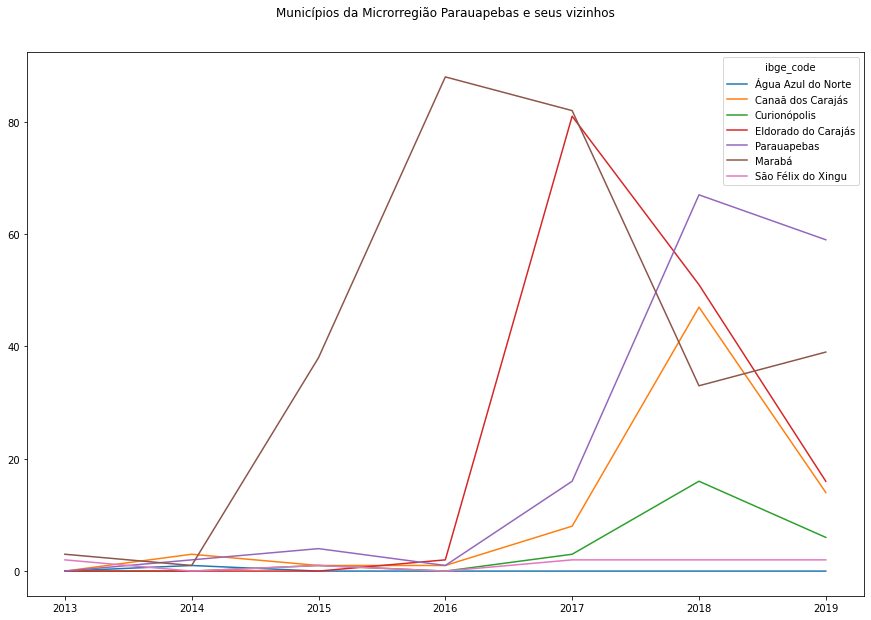

In [38]:
d = total_casos.loc[mun.index, ['2013','2014','2015','2016','2017','2018','2019']].copy()
d.index = d.index.map(dict(zip(mun.index, mun.municipio)))
d.T.plot(
    kind='line', 
    figsize=(15,10),
    title='''Municípios da Microrregião Parauapebas e seus vizinhos\n\n'''
);

- Marabá e Eldorado são municípios muito próximos.
- Parauapebas fica próximo de Marabá e Eldorado, mas não tanto. 
- Canaã fica bem próximo de Parauapebas.